<a name="top" id="top"></a>

<div align="center">
    <h1>QUBO &amp; Ising Models</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <i>PSR Energy Consulting &amp; Analytics</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/pedromxavier/QUBO-notebooks/blob/main/notebooks/1-LP_IP.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="#installation">
        <img src="https://img.shields.io/badge/⚙️-Installation_Instructions-blue" alt="Installation Instructions"/>
    </a>
    <a href="https://bernalde.github.io/">
        <img src="https://img.shields.io/badge/⚗️-Bernal_Lab-blue" alt="Bernal Lab"/>
    </a>
</div>

## Quadratic Unconstrained Binary Optimization

This notebook will explain the basics of the QUBO modeling.
In order to implement the different QUBO formulations we will use **[JuMP](https://jump.dev)**, and then solve them using **[neal](https://github.com/dwavesystems/dwave-neal)**'s implementation of simulated annealing.
We will also leverage the use of **[QUBO.jl](https://github.com/psrenergy/QUBO.jl)** to translate constraint satisfaction problems to QUBOs.
Finally, for we will use **[Graphs.jl](https://github.com/JuliaGraphs/Graphs.jl)** for network models/graphs.

## Problem statement

We define a QUBO as the following optimization problem:

$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)}Q_{ii}x_i + \beta = \min_{x \in \{0,1 \}^n}  \mathbf{x}' \mathbf{Q} \mathbf{x} + \beta
$$

where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by a weighted adjacency matrix $\mathbf{Q}$.
We also include an arbitrary offset  $\beta$.

### Example

Suppose we want to solve the following problem via QUBO

$$
\begin{array}{rl}
\displaystyle%
\min_{\mathbf{x}} & 2x_0+4x_1+4x_2+4x_3+4x_4+4x_5+5x_6+4x_7+5x_8+6x_9+5x_{10} \\
\textrm{s.t.}     & \begin{bmatrix}
1 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 1\\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}\mathbf{x}=
\begin{bmatrix}
1\\
1\\
1
\end{bmatrix} \\
~ & \mathbf{x} \in \{0,1 \}^{11}
\end{array}
$$

First we would write this problem as a an unconstrained one by penalizing the linear constraints as quadratics in the objective.
Let's first define the problem parameters.

In [166]:
A = [
    1 0 0 1 1 1 0 1 1 1 1
    0 1 0 1 0 1 1 0 1 1 1
    0 0 1 0 1 0 1 1 1 1 1
]
b = [1, 1, 1]
c = [2, 4, 4, 4, 4, 4, 5, 4, 5, 6, 5];

In order to define the $\mathbf{Q}$ matrix, we first write the problem

$$
\begin{array}{rl}
    \displaystyle%
    \min_{\mathbf{x}} &\mathbf{c}' \mathbf{x} \\
    \textrm{s.t.}     & \mathbf{A}\mathbf{x} = \mathbf{b} \\
    ~                 & \mathbf{x} \in \{0,1 \}^{11}
\end{array}
$$

as follows:

$$
\begin{array}{rl}
    \displaystyle%
    \min_{\mathbf{x}} & \mathbf{c}' \mathbf{x} + \rho (\mathbf{A}\mathbf{x}-\mathbf{b})' (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
    \textrm{s.t.}     & \mathbf{x} \in \{0,1 \}^{11}
\end{array}
$$

Exploiting the fact that $x^2=x$ for $x \in \{0,1\}$, we can make the linear terms appear in the diagonal of the $\mathbf{Q}$ matrix.

$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}^\top (\mathbf{A}^\top \mathbf{A}) \mathbf{x} - 2\mathbf{b}^\top \mathbf{A} \mathbf{x} + \mathbf{b}^\top \mathbf{b} )
$$

For this problem in particular, one can prove that a reasonable penalization factor is given by $\rho = \sum_{i=1}^n |c_i| + \epsilon$ with $\epsilon > 0$.

In [167]:
using LinearAlgebra

In [168]:
ϵ = 1
ρ = sum(abs, c) + ϵ
Q = diagm(c) + ρ * (A'A - 2 * diagm(A'b))
β = ρ * b'b

display(Q)
println(β)

11×11 Matrix{Int64}:
 -46    0    0   48   48   48    0   48    48    48    48
   0  -44    0   48    0   48   48    0    48    48    48
   0    0  -44    0   48    0   48   48    48    48    48
  48   48    0  -92   48   96   48   48    96    96    96
  48    0   48   48  -92   48   48   96    96    96    96
  48   48    0   96   48  -92   48   48    96    96    96
   0   48   48   48   48   48  -91   48    96    96    96
  48    0   48   48   96   48   48  -92    96    96    96
  48   48   48   96   96   96   96   96  -139   144   144
  48   48   48   96   96   96   96   96   144  -138   144
  48   48   48   96   96   96   96   96   144   144  -139

144


We can visualize the graph that defines this instance using the Q matrix as the adjacency matrix of a graph.

In [169]:
using Graphs

In [170]:
G = SimpleGraph(Q)

{11, 58} undirected simple Int64 graph

In [171]:
using Karnak

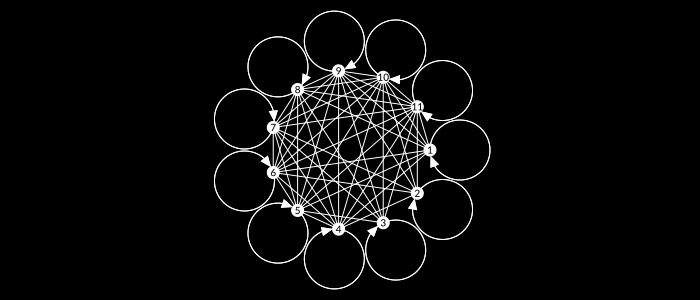

In [172]:
@drawsvg(
    begin
        sethue("white")
        background("black")
        drawgraph(
            G;
            margin=70,
            vertexlabels = 1:11,
        )
    end,
    700,
    300,
)

Let's define a QUBO model and then solve it using enumeration and D-Wave's simulated annealing (eventually with Quantum annealling too!).

In [173]:
using JuMP

In [174]:
# Define empty model
qubo_model = Model()

# Define the variables
@variable(qubo_model, x[1:11], Bin)

# Define the objective function
@objective(qubo_model, Min, x' * Q * x + β)

# Print the model
print(qubo_model)

Min -46 x[1]² + 96 x[4]*x[1] + 96 x[5]*x[1] + 96 x[6]*x[1] + 96 x[8]*x[1] + 96 x[9]*x[1] + 96 x[10]*x[1] + 96 x[11]*x[1] - 44 x[2]² + 96 x[4]*x[2] + 96 x[6]*x[2] + 96 x[7]*x[2] + 96 x[9]*x[2] + 96 x[10]*x[2] + 96 x[11]*x[2] - 44 x[3]² + 96 x[5]*x[3] + 96 x[7]*x[3] + 96 x[8]*x[3] + 96 x[9]*x[3] + 96 x[10]*x[3] + 96 x[11]*x[3] - 92 x[4]² + 96 x[5]*x[4] + 192 x[6]*x[4] + 96 x[7]*x[4] + 96 x[8]*x[4] + 192 x[9]*x[4] + 192 x[10]*x[4] + 192 x[11]*x[4] - 92 x[5]² + 96 x[6]*x[5] + 96 x[7]*x[5] + 192 x[8]*x[5] + 192 x[9]*x[5] + 192 x[10]*x[5] + 192 x[11]*x[5] - 92 x[6]² + 96 x[7]*x[6] + 96 x[8]*x[6] + 192 x[9]*x[6] + 192 x[10]*x[6] + 192 x[11]*x[6] - 91 x[7]² + 96 x[8]*x[7] + 192 x[9]*x[7] + 192 x[10]*x[7] + 192 x[11]*x[7] - 92 x[8]² + 192 x[9]*x[8] + 192 x[10]*x[8] + 192 x[11]*x[8] - 139 x[9]² + 288 x[10]*x[9] + 288 x[11]*x[9] - 138 x[10]² + 288 x[11]*x[10] - 139 x[11]² + 144
Subject to
 x[1] binary
 x[2] binary
 x[3] binary
 x[4] binary
 x[5] binary
 x[6] binary
 x[7] binary
 x[8] binary
 x[9]

Since the problem is relatively small ($11$ variables, $2^{11}=2048$ combinations), we can afford to enumerate all the solutions.

In [175]:
using QUBO

In [176]:
# Here we solve the optimization problem with GLPK
set_optimizer(qubo_model, ExactSampler.Optimizer)

optimize!(qubo_model)

qubo_x = round.(Int, value.(x))

# Display solution of the problem
println(solution_summary(qubo_model))
println("* x = $qubo_x")

* Solver : Exact Sampler

* Status
  Result count       : 2048
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  ""

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 5.00000e+00

* Work counters
  Solve time (sec)   : 1.10246e-03

* x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [177]:
using Plots

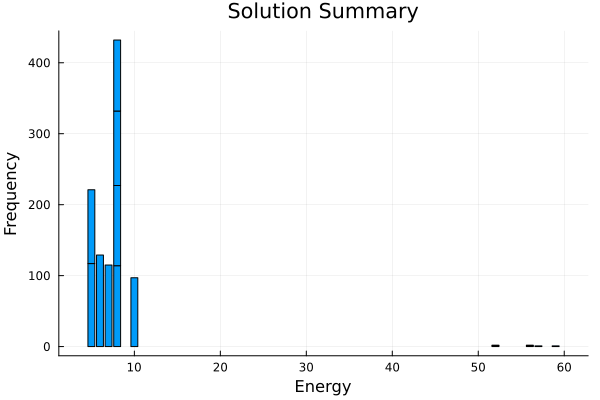

In [195]:
QUBOTools.sampleset(unsafe_backend(qubo_model)) |> Plots.plot

Let's now solve this QUBO via traditional Integer Programming.

In [179]:
qubo_ilp_model = Model()

@variable(qubo_ilp_model, x[1:11], Bin)
@variable(qubo_ilp_model, y[1:11, 1:11], Bin)

@objective(
    qubo_ilp_model,
    Min,
    sum(Q[i,j] * (i == j ? x[i] : y[i,j]) for i=1:11, j=1:11) +  β
)

@constraint(qubo_ilp_model, c1[i=1:11,j=1:11;i!=j], y[i,j] >= x[i] + x[j] - 1)
@constraint(qubo_ilp_model, c2[i=1:11,j=1:11;i!=j], y[i,j] <= x[i])
@constraint(qubo_ilp_model, c3[i=1:11,j=1:11;i!=j], y[i,j] <= x[j])

println(qubo_ilp_model)

Min -46 x[1] + 48 y[1,4] + 48 y[1,5] + 48 y[1,6] + 48 y[1,8] + 48 y[1,9] + 48 y[1,10] + 48 y[1,11] - 44 x[2] + 48 y[2,4] + 48 y[2,6] + 48 y[2,7] + 48 y[2,9] + 48 y[2,10] + 48 y[2,11] - 44 x[3] + 48 y[3,5] + 48 y[3,7] + 48 y[3,8] + 48 y[3,9] + 48 y[3,10] + 48 y[3,11] + 48 y[4,1] + 48 y[4,2] - 92 x[4] + 48 y[4,5] + 96 y[4,6] + 48 y[4,7] + 48 y[4,8] + 96 y[4,9] + 96 y[4,10] + 96 y[4,11] + 48 y[5,1] + 48 y[5,3] + 48 y[5,4] - 92 x[5] + 48 y[5,6] + 48 y[5,7] + 96 y[5,8] + 96 y[5,9] + 96 y[5,10] + 96 y[5,11] + 48 y[6,1] + 48 y[6,2] + 96 y[6,4] + 48 y[6,5] - 92 x[6] + 48 y[6,7] + 48 y[6,8] + 96 y[6,9] + 96 y[6,10] + 96 y[6,11] + 48 y[7,2] + 48 y[7,3] + 48 y[7,4] + 48 y[7,5] + 48 y[7,6] - 91 x[7] + 48 y[7,8] + 96 y[7,9] + 96 y[7,10] + 96 y[7,11] + 48 y[8,1] + 48 y[8,3] + 48 y[8,4] + 96 y[8,5] + 48 y[8,6] + 48 y[8,7] - 92 x[8] + 96 y[8,9] + 96 y[8,10] + 96 y[8,11] + 48 y[9,1] + 48 y[9,2] + 48 y[9,3] + 96 y[9,4] + 96 y[9,5] + 96 y[9,6] + 96 y[9,7] + 96 y[9,8] - 139 x[9] + 144 y[9,10] + 144 y[9,11

 c3[3,7] : -x[7] + y[3,7] ≤ 0
 c3[3,8] : -x[8] + y[3,8] ≤ 0
 c3[3,9] : -x[9] + y[3,9] ≤ 0
 c3[3,10] : -x[10] + y[3,10] ≤ 0
 c3[3,11] : -x[11] + y[3,11] ≤ 0
 c3[4,1] : -x[1] + y[4,1] ≤ 0
 c3[4,2] : -x[2] + y[4,2] ≤ 0
 c3[4,3] : -x[3] + y[4,3] ≤ 0
 c3[4,5] : -x[5] + y[4,5] ≤ 0
 c3[4,6] : -x[6] + y[4,6] ≤ 0
 c3[4,7] : -x[7] + y[4,7] ≤ 0
 c3[4,8] : -x[8] + y[4,8] ≤ 0
 c3[4,9] : -x[9] + y[4,9] ≤ 0
 c3[4,10] : -x[10] + y[4,10] ≤ 0
 c3[4,11] : -x[11] + y[4,11] ≤ 0
 c3[5,1] : -x[1] + y[5,1] ≤ 0
 c3[5,2] : -x[2] + y[5,2] ≤ 0
 c3[5,3] : -x[3] + y[5,3] ≤ 0
 c3[5,4] : -x[4] + y[5,4] ≤ 0
 c3[5,6] : -x[6] + y[5,6] ≤ 0
 c3[5,7] : -x[7] + y[5,7] ≤ 0
 c3[5,8] : -x[8] + y[5,8] ≤ 0
 c3[5,9] : -x[9] + y[5,9] ≤ 0
 c3[5,10] : -x[10] + y[5,10] ≤ 0
 c3[5,11] : -x[11] + y[5,11] ≤ 0
 c3[6,1] : -x[1] + y[6,1] ≤ 0
 c3[6,2] : -x[2] + y[6,2] ≤ 0
 c3[6,3] : -x[3] + y[6,3] ≤ 0
 c3[6,4] : -x[4] + y[6,4] ≤ 0
 c3[6,5] : -x[5] + y[6,5] ≤ 0
 c3[6,7] : -x[7] + y[6,7] ≤ 0
 c3[6,8] : -x[8] + y[6,8] ≤ 0
 c3[6,9] : -x[9] + y[6

In [180]:
using GLPK

In [181]:
set_optimizer(qubo_ilp_model, GLPK.Optimizer)

optimize!(qubo_ilp_model)

qubo_ilp_x = round.(Int, value.(x))

println(solution_summary(qubo_ilp_model))
println("* x = $qubo_ilp_x")

* Solver : GLPK

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Solution is optimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 5.00000e+00
  Objective bound    : 5.00000e+00
  Relative gap       : 9.60000e+00

* Work counters
  Solve time (sec)   : 3.92413e-03

* x = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


We observe that the optimal solution of this problem is $x_{9} = 1, 0$ otherwise, leading to an objective value of $5$.
Notice that this problem has a degenerate optimal solution given that $x_{11} = 1, 0$ otherwise also leads to the same solution.

## Ising model

This notebook will explain the basics of the Ising model.
In order to implement the different Ising Models we will use **[JuMP](https://jump.dev)** and D-Wave's **[neal](https://github.com/dwavesystems/dwave-neal)**, for defining the Ising model and solving it with simulated annealing, respectively.
When posing the problems as Integer programs, we will model using **[JuMP](https://jump.dev/)**, an open-source Julia package, which provides a flexible access to different solvers and a general modeling framework for linear and nonlinear integer programs.
The examples solved here will make use of open-source solver **[GLPK](https://www.gnu.org/software/glpk/)** for mixed-integer linear programming.

### Problem statement

We pose the Ising problem as the following optimization problem:

$$
\min_{s \in \{ \pm 1 \}^n} H(s) = \min_{s \in \{ \pm 1 \}^n} \sum_{(ij) \in E(G)} J_{i,j}s_is_j + \sum_{i \in V(G)} h_is_i + \beta
$$

where we optimize over spins $s \in \{ \pm 1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{i,j}$ and the linear coefficients are $h_i$.
We also include an arbitrary offset of the Ising model $\beta$.

### Example

Suppose we have an Ising model defined from

$$
h = \begin{bmatrix}
145.0 \\ 122.0 \\ 122.0 \\ 266.0 \\ 266.0 \\ 266.0 \\ 242.5 \\ 266.0 \\ 386.5 \\ 387.0 \\ 386.5
\end{bmatrix},
J = \begin{bmatrix}
0 & 0 & 0 & 24 & 24 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 48 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix} \text{ and }
\beta = 1319.5
$$
Let's solve this problem

In [182]:
h = [
    145.0,
    122.0,
    122.0,
    266.0,
    266.0,
    266.0,
    242.5,
    266.0,
    386.5,
    387.0,
    386.5,
]

J = [
    0  0  0 24 24 24 24 24 24 24 24
    0  0  0 24  0 24 24 24 24 24 24
    0  0  0  0 24  0 24 24 24 24 24
    0  0  0  0 24 48 24 24 48 48 48
    0  0  0  0  0 24 24 48 48 48 48
    0  0  0  0  0  0 24 24 48 48 48
    0  0  0  0  0  0  0 24 48 48 48
    0  0  0  0  0  0  0  0 48 48 48
    0  0  0  0  0  0  0  0  0 72 72
    0  0  0  0  0  0  0  0  0  0 72
    0  0  0  0  0  0  0  0  0  0  0
]

β = 1319.5

ising_model = Model()

@variable(ising_model, s[1:11], Spin)

@objective(ising_model, Min, s' * J * s + h' * s + β)

println(ising_model)

Min 24 s[4]*s[1] + 24 s[4]*s[2] + 24 s[5]*s[1] + 24 s[5]*s[3] + 24 s[5]*s[4] + 24 s[6]*s[1] + 24 s[6]*s[2] + 48 s[6]*s[4] + 24 s[6]*s[5] + 24 s[7]*s[1] + 24 s[7]*s[2] + 24 s[7]*s[3] + 24 s[7]*s[4] + 24 s[7]*s[5] + 24 s[7]*s[6] + 24 s[8]*s[1] + 24 s[8]*s[2] + 24 s[8]*s[3] + 24 s[8]*s[4] + 48 s[8]*s[5] + 24 s[8]*s[6] + 24 s[8]*s[7] + 24 s[9]*s[1] + 24 s[9]*s[2] + 24 s[9]*s[3] + 48 s[9]*s[4] + 48 s[9]*s[5] + 48 s[9]*s[6] + 48 s[9]*s[7] + 48 s[9]*s[8] + 24 s[10]*s[1] + 24 s[10]*s[2] + 24 s[10]*s[3] + 48 s[10]*s[4] + 48 s[10]*s[5] + 48 s[10]*s[6] + 48 s[10]*s[7] + 48 s[10]*s[8] + 72 s[10]*s[9] + 24 s[11]*s[1] + 24 s[11]*s[2] + 24 s[11]*s[3] + 48 s[11]*s[4] + 48 s[11]*s[5] + 48 s[11]*s[6] + 48 s[11]*s[7] + 48 s[11]*s[8] + 72 s[11]*s[9] + 72 s[11]*s[10] + 145 s[1] + 122 s[2] + 122 s[3] + 266 s[4] + 266 s[5] + 266 s[6] + 242.5 s[7] + 266 s[8] + 386.5 s[9] + 387 s[10] + 386.5 s[11] + 1319.5
Subject to
 s[1] spin
 s[2] spin
 s[3] spin
 s[4] spin
 s[5] spin
 s[6] spin
 s[7] spin
 s[8] spin
 s[9] 

In [183]:
set_optimizer(ising_model, ExactSampler.Optimizer)

optimize!(ising_model)

ising_s = round.(Int, value.(s))

# Display solution of the problem
println(solution_summary(ising_model))
println("* s = $ising_s")

* Solver : Exact Sampler

* Status
  Result count       : 2048
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  ""

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : -3.80000e+01

* Work counters
  Solve time (sec)   : 9.29941e-04

* s = [1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]


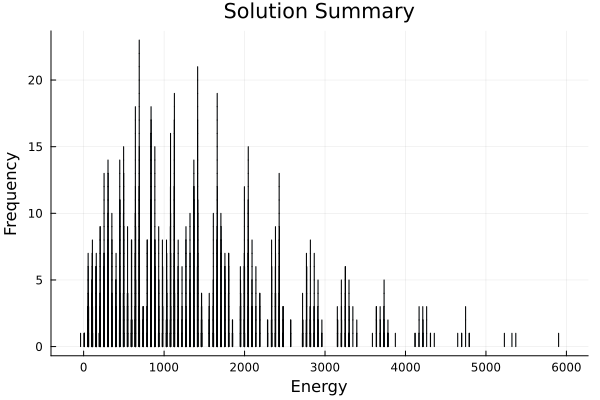

In [194]:
QUBOTools.sampleset(unsafe_backend(ising_model)) |> Plots.plot

In [185]:
Q, α, β = QUBOTools.qubo(unsafe_backend(ising_model), Matrix)

([-94.0 0.0 … 96.0 96.0; 0.0 -92.0 … 96.0 96.0; … ; 0.0 0.0 … -138.0 288.0; 0.0 0.0 … 0.0 -139.0], 1.0, 192.0)

In [186]:
ising_ilp_model = Model()

@variable(ising_ilp_model, x[1:11], Bin)
@variable(ising_ilp_model, y[1:11, 1:11], Bin)

@objective(
    ising_ilp_model,
    Min,
    sum(Q[i,j] * (i == j ? x[i] : y[i,j]) for i=1:11, j=1:11) +  β
)

@constraint(ising_ilp_model, c1[i=1:11,j=1:11;i!=j], y[i,j] >= x[i] + x[j] - 1)
@constraint(ising_ilp_model, c2[i=1:11,j=1:11;i!=j], y[i,j] <= x[i])
@constraint(ising_ilp_model, c3[i=1:11,j=1:11;i!=j], y[i,j] <= x[j])

println(ising_ilp_model)

Min -94 x[1] + 96 y[1,4] + 96 y[1,5] + 96 y[1,6] + 96 y[1,7] + 96 y[1,8] + 96 y[1,9] + 96 y[1,10] + 96 y[1,11] - 92 x[2] + 96 y[2,4] + 96 y[2,6] + 96 y[2,7] + 96 y[2,8] + 96 y[2,9] + 96 y[2,10] + 96 y[2,11] - 44 x[3] + 96 y[3,5] + 96 y[3,7] + 96 y[3,8] + 96 y[3,9] + 96 y[3,10] + 96 y[3,11] - 92 x[4] + 96 y[4,5] + 192 y[4,6] + 96 y[4,7] + 96 y[4,8] + 192 y[4,9] + 192 y[4,10] + 192 y[4,11] - 92 x[5] + 96 y[5,6] + 96 y[5,7] + 192 y[5,8] + 192 y[5,9] + 192 y[5,10] + 192 y[5,11] - 92 x[6] + 96 y[6,7] + 96 y[6,8] + 192 y[6,9] + 192 y[6,10] + 192 y[6,11] - 139 x[7] + 96 y[7,8] + 192 y[7,9] + 192 y[7,10] + 192 y[7,11] - 140 x[8] + 192 y[8,9] + 192 y[8,10] + 192 y[8,11] - 139 x[9] + 288 y[9,10] + 288 y[9,11] - 138 x[10] + 288 y[10,11] - 139 x[11] + 192
Subject to
 c1[1,2] : -x[1] - x[2] + y[1,2] ≥ -1
 c1[1,3] : -x[1] - x[3] + y[1,3] ≥ -1
 c1[1,4] : -x[1] - x[4] + y[1,4] ≥ -1
 c1[1,5] : -x[1] - x[5] + y[1,5] ≥ -1
 c1[1,6] : -x[1] - x[6] + y[1,6] ≥ -1
 c1[1,7] : -x[1] - x[7] + y[1,7] ≥ -1
 c1[1,8

 c3[5,2] : -x[2] + y[5,2] ≤ 0
 c3[5,3] : -x[3] + y[5,3] ≤ 0
 c3[5,4] : -x[4] + y[5,4] ≤ 0
 c3[5,6] : -x[6] + y[5,6] ≤ 0
 c3[5,7] : -x[7] + y[5,7] ≤ 0
 c3[5,8] : -x[8] + y[5,8] ≤ 0
 c3[5,9] : -x[9] + y[5,9] ≤ 0
 c3[5,10] : -x[10] + y[5,10] ≤ 0
 c3[5,11] : -x[11] + y[5,11] ≤ 0
 c3[6,1] : -x[1] + y[6,1] ≤ 0
 c3[6,2] : -x[2] + y[6,2] ≤ 0
 c3[6,3] : -x[3] + y[6,3] ≤ 0
 c3[6,4] : -x[4] + y[6,4] ≤ 0
 c3[6,5] : -x[5] + y[6,5] ≤ 0
 c3[6,7] : -x[7] + y[6,7] ≤ 0
 c3[6,8] : -x[8] + y[6,8] ≤ 0
 c3[6,9] : -x[9] + y[6,9] ≤ 0
 c3[6,10] : -x[10] + y[6,10] ≤ 0
 c3[6,11] : -x[11] + y[6,11] ≤ 0
 c3[7,1] : -x[1] + y[7,1] ≤ 0
 c3[7,2] : -x[2] + y[7,2] ≤ 0
 c3[7,3] : -x[3] + y[7,3] ≤ 0
 c3[7,4] : -x[4] + y[7,4] ≤ 0
 c3[7,5] : -x[5] + y[7,5] ≤ 0
 c3[7,6] : -x[6] + y[7,6] ≤ 0
 c3[7,8] : -x[8] + y[7,8] ≤ 0
 c3[7,9] : -x[9] + y[7,9] ≤ 0
 c3[7,10] : -x[10] + y[7,10] ≤ 0
 c3[7,11] : -x[11] + y[7,11] ≤ 0
 c3[8,1] : -x[1] + y[8,1] ≤ 0
 c3[8,2] : -x[2] + y[8,2] ≤ 0
 c3[8,3] : -x[3] + y[8,3] ≤ 0
 c3[8,4] : -x[4] + y[8

In [187]:
set_optimizer(ising_ilp_model, GLPK.Optimizer)

optimize!(ising_ilp_model)

ising_ilp_x = round.(Int, value.(x))

println(solution_summary(ising_ilp_model))
println("* x = $ising_ilp_x")

* Solver : GLPK

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Solution is optimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : -3.80000e+01
  Objective bound    : -3.80000e+01
  Relative gap       : 2.63158e-02

* Work counters
  Solve time (sec)   : 3.14093e-03

* x = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


We observe that the optimal solution of this problem is $x_{1} = x_{2} = x_{3} = 1, 0$ otherwise, leading to an objective of $-38$.

## Let's go back to the slides

Let's now solve the QUBO problem using Simulated Annealing

In [189]:
using DWaveNeal

In [192]:
set_optimizer(qubo_model, DWaveNeal.Optimizer)

set_optimizer_attribute(qubo_model, "num_reads", 1_000)

optimize!(qubo_model)

x = qubo_model[:x]

qubo_x = round.(Int, value.(x))

println(solution_summary(qubo_model))
println("* x = $qubo_x")

* Solver : D-Wave Neal Simulated Annealing Sampler

* Status
  Result count       : 15
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  ""

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 5.00000e+00

* Work counters
  Solve time (sec)   : 2.20978e-01

* x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


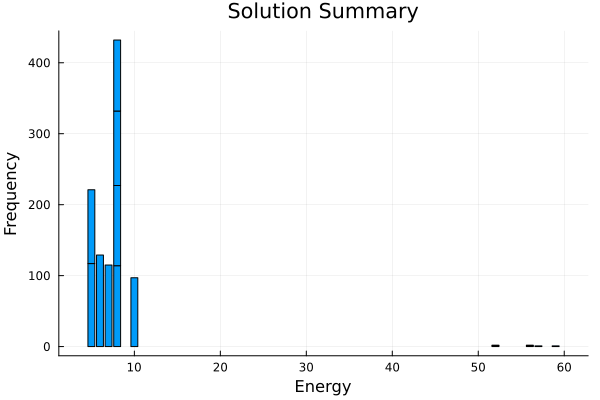

In [196]:
QUBOTools.sampleset(unsafe_backend(qubo_model)) |> Plots.plot

Notice that this is the same example we have been solving earlier (via Integer Programming in the Quiz 1 and Ising model above).

## Let's go back to the slides

Let's solve the graph coloring problem in the slides using QUBO.

#### Vertex $k$-coloring of graphs

Given a graph $G(V, E)$, where $V$ is the set of vertices and $E$ is the set of edges of $G$, and a positive integer $k$, we ask if it is possible to assign a color to every vertex from $V$, such that adjacent vertices have different colors assigned.

$G(V, E)$ has $12$ vertices and $23$ edges.
We ask if the graph is $3$–colorable.
Let’s first encode $V$ and $E$ using Julia’s built–in data structures:

**Note:** This second tutorial is heavily inspired in D-Wave's Map coloring of Canada found **[here](https://docs.ocean.dwavesys.com/en/stable/examples/map_coloring.html)**.

In [242]:
V = 1:12
E = [
    (1,2), (1,4), (1,6), (1,12),
    (2,3), (2,5), (2,7),
    (3,8), (3,10),
    (4,9), (4,11),
    (5,6), (5,9), (5,12),
    (6,7), (6,10),
    (7,8), (7,11),
    (8,9), (8,12),
    (9,10),
    (10,11),
    (11,12),
]

G = SimpleGraph(Edge.(E))

{12, 23} undirected simple Int64 graph

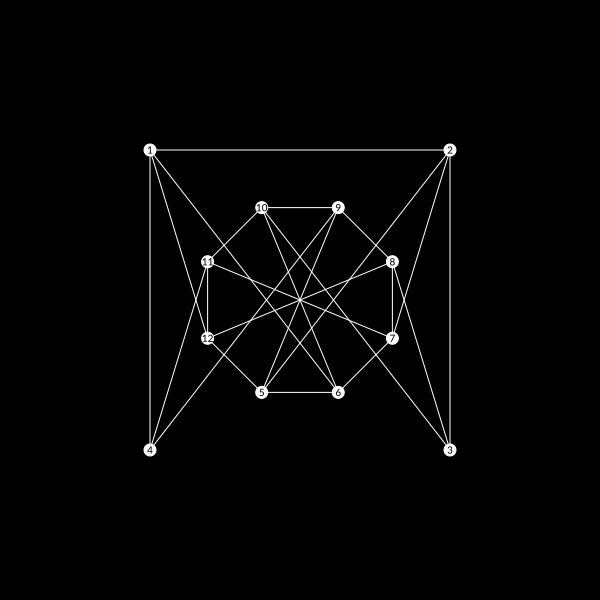

In [243]:
graph_layout = Vector{Point}(undef, 12)

graph_layout[1] = Point(-1.5,-1.5)
graph_layout[2] = Point(1.5,-1.5)
graph_layout[3] = Point(1.5,1.5)
graph_layout[4] = Point(-1.5,1.5)

for i in 5:12
    graph_layout[i] = Point(cos((2i+1) * π/8), -sin((2i+1) * π/8))
end

@drawsvg(
    begin
        sethue("white")
        background("black")
        drawgraph(
            G;
            layout=100 * graph_layout,
            margin=70,
            vertexlabels = V,
        )
    end,
)

In [245]:
# Function for the constraint that two nodes with a shared edge not both select
# one color
∧(x, y) = x * y

# Valid configurations for the constraint that each node select a single color, in this case we want to use 3 colors
color_model = Model()

@variable(color_model, c[1:12,1:3], Bin)

# Each node must be colored with exactly one color
@constraint(color_model, [i=1:12], sum(c[i,:]) == 1)

# Add constraint that each pair of nodes with a shared edge not both select one color
@constraint(color_model, [(i,j) ∈ E, k=1:3], c[i, k] * c[j,k] == 0)

2-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarQuadraticFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},2,...} with index sets:
    Dimension 1, [(1, 2), (1, 4), (1, 6), (1, 12), (2, 3), (2, 5), (2, 7), (3, 8), (3, 10), (4, 9)  …  (5, 12), (6, 7), (6, 10), (7, 8), (7, 11), (8, 9), (8, 12), (9, 10), (10, 11), (11, 12)]
    Dimension 2, Base.OneTo(3)
And data, a 23×3 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarQuadraticFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 c[1,1]*c[2,1] = 0    c[1,2]*c[2,2] = 0    c[1,3]*c[2,3] = 0
 c[1,1]*c[4,1] = 0    c[1,2]*c[4,2] = 0    c[1,3]*c[4,3] = 0
 c[1,1]*c[6,1] = 0    c[1,2]*c[6,2] = 0    c[1,3]*c[6,3] = 0
 c[1,1]*c[12,1] = 0   c[1,2]*c[12,2] = 0   c[1,3]*c[12,3] = 0
 c[2,1]*c[3,1] = 0    c[2,2]*c[3,2] = 0    c[2,3]*c[3,3] = 0
 c[2,1]*c[5,1] = 0    c[2,2]*c[5,2] = 0    c[2,3]*c[5,3] = 0
 c[2,1]*c[7,1] = 0    c

In [247]:
optimize!(color_model)

color_c = round.(Int, value.(c))

println(solution_summary(color_model))
println("* c = $color_c")

* Solver : Virtual Model

* Status
  Result count       : 172
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  ""

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 0.00000e+00

* Work counters
  Solve time (sec)   : 7.59525e-01

* c = [0 0 1; 0 1 0; 1 0 0; 1 0 0; 0 0 1; 0 1 0; 1 0 0; 0 0 1; 0 1 0; 0 0 1; 0 1 0; 1 0 0]


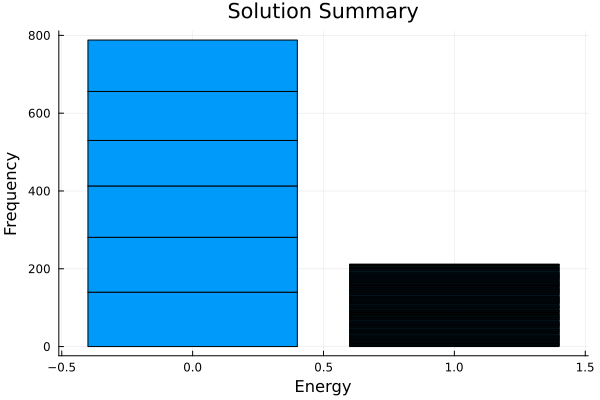

In [249]:
QUBOTools.sampleset(unsafe_backend(color_model).optimizer) |> Plots.plot

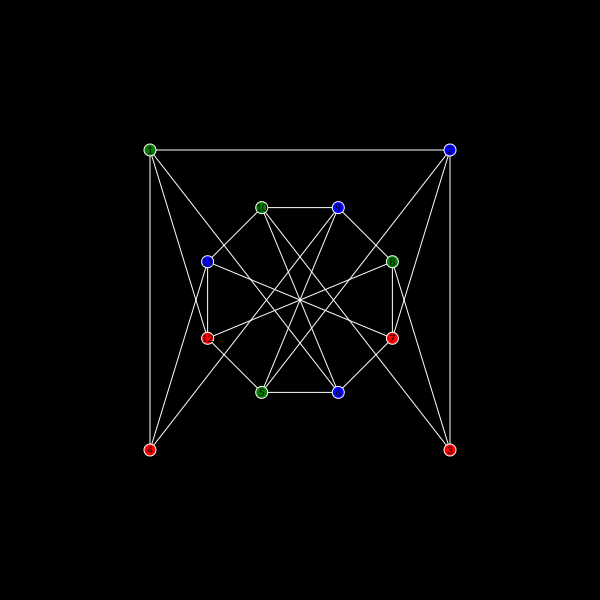

In [255]:
@drawsvg(
    begin
        sethue("white")
        background("black")
        drawgraph(
            G;
            layout=100 * graph_layout,
            margin=70,
            vertexlabels = V,
            vertexfillcolors = (v) -> begin
                if color_c[v,1] > 0
                    return colorant"red"
                elseif color_c[v,2] > 0
                    return colorant"blue"
                elseif color_c[v,3] > 0
                    return colorant"green"
                else
                    return colorant"white"
                end
            end
        )
    end,
)

# References

- [Julia Colab Notebook Template](https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_Colab_Notebook_Template.ipynb)
- [QuIPML22](https://github.com/bernalde/QuIPML22/blob/main/notebooks/Notebook%201%20-%20LP%20and%20IP.ipynb)

<a name="installation" id="installation"></a>

# Installation

## Colab Instructions

1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia and IJulia. This can take a couple of minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [ ]:
%%shell

bash <(curl -s "https://raw.githubusercontent.com/pedromxavier/QUBO-notebooks/main/scripts/install-colab-julia.sh")

## Validate Installation

In [26]:
versioninfo()

Julia Version 1.9.1
Commit 147bdf428cd (2023-06-07 08:27 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 8 × 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, tigerlake)
  Threads: 1 on 8 virtual cores
Environment:
  JULIA_NUM_THREADS = 
  JULIA_IMAGE_THREADS = 1


## Install Julia Packages

In [5]:
import Pkg

Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating new project at `~/gits/QUBO-notebooks/notebooks`


## Installing Powerful commercial solvers

### Gurobi

Gurobi is one of the most powerful LP and MIP solvers available today.
They provide free academic licenses.
In order to install the software, visit their **[Website](https://www.gurobi.com/)**, create an account (preferably with your academic email), and obtain a license.
Once you do that, you can download and use the software.

### BARON

BARON is one of the most powerful MINLP solvers available today.
Students from the University System of Georgia or CMU and UIUC affiliates are eligible for a free license. 
In order to install the software, visit their **[Website](https://www.minlp.com/home)**, create an account (with your academic email), and obtain a license.
Once you do that you can download and use the software.

<div align="center">
    <a href="#top">🔝 Go back to the top 🔝</a>
</div>